<a href="https://colab.research.google.com/github/DanileRond/ARAP/blob/main/Basic_Policy_Gradients_(REINFORCE)_example_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Policy Gradients (REINFORCE) example in PyTorch

> Bloque con sangría

> Bloque con sangría





This notebook is adapted from the [official REINFORCE tutorial](https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py).

## Installing dependencies

We will use OpenAI Gym to simulate the environment, which might not be installed by default. We also need to install some dependencies for visualization purposes (this may take a while).

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Setting up the environment

We will need some tricks to visualize the simulations in the browser, as simply calling env.render() will not work in this notebook ([source](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=Jyb2Ujuozfi2&forceEdit=true&offline=true&sandboxMode=true)).

In [2]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [3]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
print('PyTorch version: ', torch.__version__)

PyTorch version:  1.7.0+cu101


In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Visualize a random policy in the environment

Our goal is to train an agent that is capable of solving the CartPole problem, where a pole is attached to a cart moving along a horizontal track. The agent can interact with the environment by applying a force (+1/-1) to the cart. The episode is terminated whenever the pole is more than 15 degrees from vertical or the cart goes out of bounds in the horizontal axis. The agent receives +1 reward for each timestep under the desired conditions.

We can visualize what a random policy would do in this environment:

In [8]:
# Let's generate a random trajectory...
env = wrap_env(gym.make("CartPole-v1"))
ob, done, total_rew = env.reset(), False, 0
while not done:
  env.render()
  ac = env.action_space.sample()
  ob, rew, done, info = env.step(ac)
  total_rew += rew
print('Cumulative reward:', total_rew)
  
# ... and visualize it!
env.close()
show_video()

Cumulative reward: 24.0


## Create the model

Now we will define our policy, parameterized by a feedforward neural network.

**Exercise #1.** Implement the policy as an MLP with a hidden layer of 128 neurons with a ReLU activation and a Softmax output layer.

In [9]:
class Policy(nn.Module):
    def __init__(self, inputs, outputs):
        super(Policy, self).__init__()
        # DONE
        self.affine1 = nn.Linear(inputs, 128)
        self.affine2 = nn.Linear(128, outputs)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        # DONE
        x = self.affine1(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

## Functions for collecting experience and updating the policy

**Exercise #2.** Use the policy to predict a distribution of probabilities across actions.

**Exercise #3.** Compute the return from the rewards collected by the policy.

**Exercise #4.** Complete the loss computation using the returns and the log probs.

In [31]:
def select_action(policy, state):
    # Convert state into PyTorch tensor
    state = torch.from_numpy(state).float().unsqueeze(0)
    # TODO: Compute action probabilities
    probs = policy(state)
    # Sample action
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    # Bookkeeping
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def train(policy, optimizer):
    R = 0
    policy_loss = []
    returns = []
    # Compute the returns by reading the rewards vector backwards
    for r in policy.rewards[::-1]:
        # TODO: Complete the computation of the return using gamma
        R = r + gamma*R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    # Normalize returns (this usually accelerates convergence)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        # TODO: Complete the 'loss' computation using the returns and the log probs.
        policy_loss.append(-log_prob*R)
    # Update policy: 
    #  (1) reset optimizer grads
    optimizer.zero_grad()
    #  (2) compute surrogate policy gradients loss
    policy_loss = torch.cat(policy_loss).sum()
    #  (3) SGD step
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

## Training the agent

In [32]:
# Hyperparameters
env_name = 'CartPole-v1'
gamma = 0.99  # discount factor
seed = 543  # random seed
log_interval = 10  # controls how often we log progress
max_ep_len = 1000  # maximum episode length
num_episodes = 1500  # number of episodes to train on

In [33]:
# Create environment
env = gym.make(env_name)

# Fix random seed (for reproducibility)
env.seed(seed)
torch.manual_seed(seed)

In [34]:
# Create policy and optimizer
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n
policy = Policy(n_inputs, n_actions)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


# Training loop
print("Target reward: {}".format(env.spec.reward_threshold))
running_reward = 10
ep_rew_history_reinforce = []
for i_episode in range(num_episodes):
    # Collect experience
    state, ep_reward = env.reset(), 0
    for t in range(max_ep_len):  # Don't infinite loop while learning
        
        action = select_action(policy, state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    # Update running reward
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    
    # Perform training step
    train(policy, optimizer)
    ep_rew_history_reinforce.append((i_episode, ep_reward))
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
              i_episode, ep_reward, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved!")
        break

print("Finished training! Running reward is now {:.2f} and "
      "the last episode runs to {} time steps!".format(running_reward, t))

Target reward: 475.0
Episode 0	Last reward: 12.00	Average reward: 10.10
Episode 10	Last reward: 16.00	Average reward: 12.44
Episode 20	Last reward: 10.00	Average reward: 12.67
Episode 30	Last reward: 11.00	Average reward: 12.02
Episode 40	Last reward: 10.00	Average reward: 11.69
Episode 50	Last reward: 28.00	Average reward: 13.71
Episode 60	Last reward: 109.00	Average reward: 28.51
Episode 70	Last reward: 87.00	Average reward: 35.83
Episode 80	Last reward: 105.00	Average reward: 69.43
Episode 90	Last reward: 131.00	Average reward: 109.18
Episode 100	Last reward: 96.00	Average reward: 132.05
Episode 110	Last reward: 99.00	Average reward: 133.43
Episode 120	Last reward: 500.00	Average reward: 188.68
Episode 130	Last reward: 156.00	Average reward: 211.09
Episode 140	Last reward: 130.00	Average reward: 181.74
Episode 150	Last reward: 204.00	Average reward: 160.59
Episode 160	Last reward: 129.00	Average reward: 167.50
Episode 170	Last reward: 114.00	Average reward: 144.16
Episode 180	Last r

Text(0, 0.5, 'Reward')

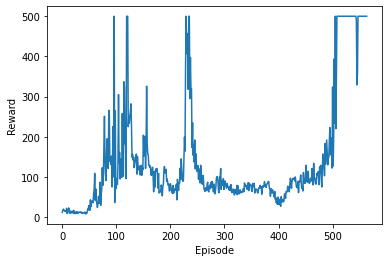

In [35]:
plt.plot([x[0] for x in ep_rew_history_reinforce], [x[1] for x in ep_rew_history_reinforce])
plt.xlabel('Episode')
plt.ylabel('Reward')

## Visualize trained policy

In [36]:
test_env = wrap_env(gym.make(env_name))
state, ep_reward, done = test_env.reset(), 0, False
while not done:
    test_env.render()
    action = select_action(policy, state)
    state, reward, done, _ = test_env.step(action)
    ep_reward += reward
print("Cumulative reward: {}".format(ep_reward))

test_env.close()
show_video()

Cumulative reward: 500.0


# REINFORCE w/ Baseline Version

## The new Policy Module encodes both Actor and Critic's Network.
**Exercise #5.** Complete the forward pass using the corresponding actor and critic's heads.


In [37]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, inputs, actor_output, critic_output):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(inputs, 128)

        # actor's layer
        self.actor_head = nn.Linear(128, actor_output)

        # critic's layer
        self.critic_head = nn.Linear(128, critic_output)

        # action & reward buffer
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # returns probability of each action
        action_prob = F.softmax(self.actor_head(x), dim=-1)

        # evaluates being in the state s_t
        state_values = self.critic_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values

## Now we want to store also the state-value for each step

In [39]:
def select_action(model, state):
    # Convert state into PyTorch tensor
    state = torch.from_numpy(state).float().unsqueeze(0)
    # Compute action probabilities and state value
    probs, state_value = model(state)
    # Sample action
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    # Bookkeeping
    model.saved_log_probs.append(SavedAction(m.log_prob(action), state_value))

    return action.item()


## The gradient computation
$$ g = \mathbb{E}\left[{\sum_{t=0}^{\infty} \Psi_t \nabla_{\theta} \log \pi_{\theta}(a_t |s_t)}\right]$$
## with REINFORCE, $\Psi_t $ was defined as 
$$ \Psi_t =  \sum_{t'=t}^\infty r_{t'} $$
## but now we will substract a baseline learned with the Critic Network
$$ \Psi_t =  \sum_{t'=t}^\infty (r_{t'}-b(s_t)) $$

**Exercise #6.** Compute the advantages by substracting the baselines to the returns.

In [40]:
def train(model, optimizer):
    R = 0
    policy_losses = []
    value_losses = []
    returns = []
    # Compute discounted rewards
    for r in model.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    # Normalize returns (this usually accelerates convergence)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, baseline), R in zip(model.saved_log_probs, returns):
        advantage = R - baseline.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(baseline, torch.tensor([R])))


    # Update policy: 
    #  (1) reset optimizer grads
    optimizer.zero_grad()
    #  (2) compute surrogate policy gradients loss
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    #  (3) SGD step
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_log_probs[:]

## Train the agent again

In [41]:
# Create environment
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
env = gym.make(env_name)

# Fix random seed (for reproducibility)
env.seed(seed)
torch.manual_seed(seed)

In [42]:
# Create policy and optimizer
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n
policy = Policy(n_inputs, n_actions, 1)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


# Training loop
print("Target reward: {}".format(env.spec.reward_threshold))
running_reward = 10
ep_rew_history_baseline = []
for i_episode in range(num_episodes):
    # Collect experience
    state, ep_reward = env.reset(), 0
    for t in range(max_ep_len):  # Don't infinite loop while learning
        action = select_action(policy, state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    # Update running reward
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    
    # Perform training step
    train(policy, optimizer)
    ep_rew_history_baseline.append((i_episode, ep_reward))
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
              i_episode, ep_reward, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved!")
        break

print("Finished training! Running reward is now {:.2f} and "
      "the last episode runs to {} time steps!".format(running_reward, t))

Target reward: 475.0
Episode 0	Last reward: 13.00	Average reward: 10.15
Episode 10	Last reward: 13.00	Average reward: 10.76
Episode 20	Last reward: 15.00	Average reward: 11.42


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 30	Last reward: 34.00	Average reward: 14.37
Episode 40	Last reward: 30.00	Average reward: 26.04
Episode 50	Last reward: 60.00	Average reward: 29.79
Episode 60	Last reward: 112.00	Average reward: 44.50
Episode 70	Last reward: 412.00	Average reward: 119.79
Episode 80	Last reward: 93.00	Average reward: 151.47
Episode 90	Last reward: 500.00	Average reward: 167.06
Episode 100	Last reward: 366.00	Average reward: 192.81
Episode 110	Last reward: 390.00	Average reward: 250.39
Episode 120	Last reward: 277.00	Average reward: 314.54
Episode 130	Last reward: 262.00	Average reward: 373.82
Episode 140	Last reward: 148.00	Average reward: 286.72
Episode 150	Last reward: 166.00	Average reward: 222.31
Episode 160	Last reward: 298.00	Average reward: 227.59
Episode 170	Last reward: 500.00	Average reward: 297.82
Episode 180	Last reward: 500.00	Average reward: 371.19
Episode 190	Last reward: 277.00	Average reward: 373.47
Episode 200	Last reward: 245.00	Average reward: 341.84
Episode 210	Last reward: 

Text(0, 0.5, 'Reward')

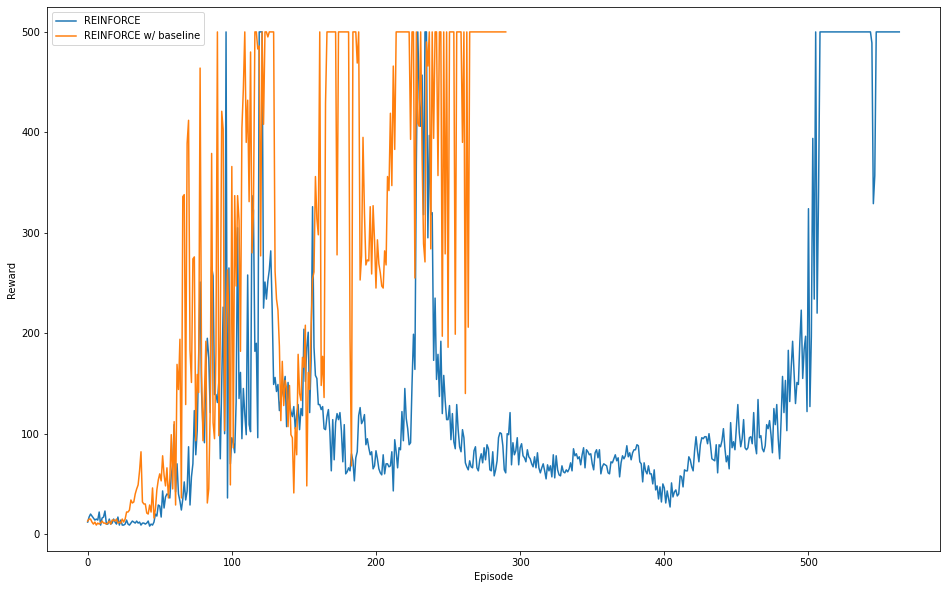

In [43]:
fig, ax = plt.subplots(figsize=(16,10))
plt.plot([x[0] for x in ep_rew_history_reinforce], [x[1] for x in ep_rew_history_reinforce])
plt.plot([x[0] for x in ep_rew_history_baseline], [x[1] for x in ep_rew_history_baseline])
plt.legend(['REINFORCE', 'REINFORCE w/ baseline'])
plt.xlabel('Episode')
plt.ylabel('Reward')

## Visualize trained policy

In [44]:
test_env = wrap_env(gym.make(env_name))
state, ep_reward, done = test_env.reset(), 0, False
while not done:
    test_env.render()
    action = select_action(policy, state)
    state, reward, done, _ = test_env.step(action)
    ep_reward += reward
print("Cumulative reward: {}".format(ep_reward))

test_env.close()
show_video()

Cumulative reward: 500.0
